In [2]:
#import matplotlib.pyplot as plt
#import numpy as np
#import seaborn as sns
#import math
#from scipy import stats
#print("imported " + str(len(raw)) + " rows")
#raw.columns.tolist()

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
import matplotlib.pyplot as plt
from IPython.display import HTML, display
import tabulate
import numpy as np
from matplotlib import cm
raw = pd.pandas.read_csv('../setup_data/pred_1x0_20181130.csv',sep=",",low_memory=False)

## Functions

def print_list(list_in):
    display(HTML(tabulate.tabulate(list_in, tablefmt='html')))

In [3]:
### CLEAN DATA FUNC

def clean_func(data,predictors):
    
    ## DO IMPUTATION 
    # living_area
    floor = Imputer(missing_values="NaN", strategy="mean")
    floor.fit(data[["floor"]])
    data['floor'] = floor.transform(data[["floor"]]).ravel()
    
    ## REMOVE ROWS w. NULL
    data = data[pd.notnull(data[predictors]).all(axis=1)]
    return data


In [4]:
## set predictors
predictors = ['min_distance_to_metro','living_area'
              ,'floor','sqm_list_price','sqm_rent_price'
              ,'area_from_geo']

## set numeric predictors
num_types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64','uint8']
train_data_numerics = raw[predictors].select_dtypes(include=num_types).columns

In [5]:
## Set target and clean data (se function above)
target = 'sqm_sold_price'
train_data = clean_func(raw,predictors)

train_data_predictors = train_data[predictors]
train_data_target = train_data[target].values

In [6]:
## Split Train/test
X_train, X_test, y_train, y_test = train_test_split(train_data_predictors, train_data_target, test_size=0.33, random_state=42)

# Linear Regression

In [7]:
## TRAIN MODEL
from sklearn import linear_model
lin_reg = linear_model.LinearRegression()

lin_reg.fit(X_train[train_data_numerics],y_train)

print("Coefficients")
print_list(list(zip(train_data_numerics,lin_reg.coef_)))

Coefficients


min_distance_to_metro,-1.18663
living_area,-141.889
floor,59.1866
sqm_list_price,1.07014
sqm_rent_price,-56.2497


In [8]:
## PREDICT
lin_reg_pred_y_test = lin_reg.predict(X_test[train_data_numerics])
lin_reg_pred_y_train = lin_reg.predict(X_train[train_data_numerics])


Mean error train:
5422.63486872
Mean error test:
5126.32507062


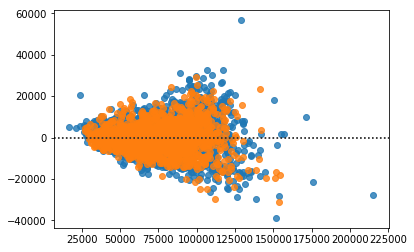

In [9]:
## METRICS
import seaborn as sns
errors_tets = (((y_test - lin_reg_pred_y_test)**2)**0.5)
errors_train = (((y_train - lin_reg_pred_y_train)**2)**0.5)
print("Mean error train:")
print(errors_train.mean())
print("Mean error test:")
print(errors_tets.mean())


sns.residplot(lin_reg_pred_y_train, y_train, label="train_error");
sns.residplot(lin_reg_pred_y_test, y_test, label="test_error");
plt.show()

# Random Forest Regressor

In [10]:
## TRAIN MODEL
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor(max_depth=10, random_state=0, n_estimators=30)
rf_reg.fit(X_train[train_data_numerics],y_train)

print("Feature Importance")
print_list(list(zip(train_data_numerics,rf_reg.feature_importances_)))

Feature Importance


min_distance_to_metro,0.0142993
living_area,0.045762
floor,0.00713076
sqm_list_price,0.919314
sqm_rent_price,0.0134941


In [11]:
## PREDICT
rf_reg_pred_y_test = rf_reg.predict(X_test[train_data_numerics])
rf_reg_pred_y_train = rf_reg.predict(X_train[train_data_numerics])


Mean error train:
3210.69572896
Mean error test:
4836.84133826


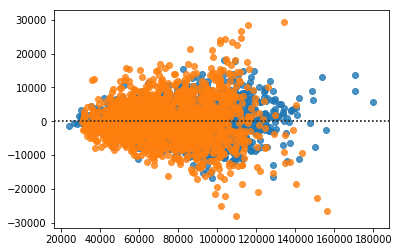

In [12]:
## METRICS
import seaborn as sns
errors_tets = (((y_test - rf_reg_pred_y_test)**2)**0.5)
errors_train = (((y_train - rf_reg_pred_y_train)**2)**0.5)
print("Mean error train:")
print(errors_train.mean())
print("Mean error test:")
print(errors_tets.mean())


sns.residplot(rf_reg_pred_y_train, y_train, label="train_error");
sns.residplot(rf_reg_pred_y_test, y_test, label="test_error");
plt.show()

# Grid Search - RF


In [51]:


param_grid = {
      'model':'RandomForestRegressor'
      ,'max_depth': [6,7,8,9,10]
      , 'n_estimators': [40, 50, 60, 70, 80,90, 100]}

## define empty 2d array to fill with eval metrics
models_test = np.full((len(param_grid['max_depth']), len(param_grid['n_estimators'])), 0)
models_train = np.full((len(param_grid['max_depth']), len(param_grid['n_estimators'])), 0)

for i,depth in enumerate(param_grid['max_depth']):
    for j,n in enumerate(param_grid['n_estimators']):
        model_output = {}
        rf_reg = RandomForestRegressor(max_depth=depth, random_state=0, n_estimators=n)
        rf_reg.fit(X_train[train_data_numerics],y_train)
        rf_reg_pred_y_test = rf_reg.predict(X_test[train_data_numerics])
        rf_reg_pred_y_train = rf_reg.predict(X_train[train_data_numerics])
        
        ## save errors to matrix
        model_output_test_res = (((y_test - rf_reg_pred_y_test)**2)**0.5).mean()
        model_output_train_res = (((y_train - rf_reg_pred_y_train)**2)**0.5).mean()
        models_test[i,j] = model_output_test_res
        models_train[i,j] = model_output_train_res




        

<IPython.core.display.Javascript object>


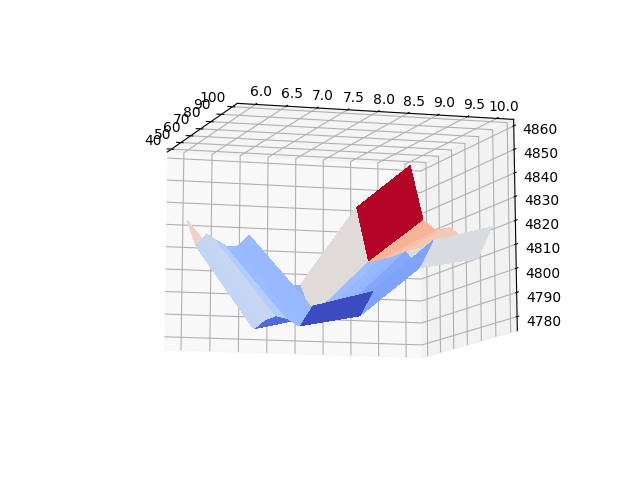

In [52]:

from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook
fig = plt.figure()
ax = fig.gca(projection='3d')
# Make data.
xx, yy = np.meshgrid(np.asarray(param_grid["n_estimators"]), np.asarray(param_grid["max_depth"]), sparse=True)

# Plot the surface.
surf = ax.plot_surface(xx, yy, models_test, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)


# best 
# 80 trees
# 7 depth

# GradientBoostingRegressor

In [23]:
## TRAIN MODEL
from sklearn.ensemble import GradientBoostingRegressor
gb_reg = GradientBoostingRegressor(n_estimators=30,learning_rate=0.1)#loss='quantile', learning_rate=0.0001, n_estimators=50, max_features='log2', min_samples_split=2, max_depth=1)
gb_reg.fit(X_train[train_data_numerics],y_train)

print("Feature Importance")
print_list(list(zip(train_data_numerics,gb_reg.feature_importances_)))


Feature Importance


min_distance_to_metro,0.0192185
living_area,0.135505
floor,0.000959025
sqm_list_price,0.824037
sqm_rent_price,0.0202805


In [24]:
## PREDICT
gb_reg_pred_y_test = gb_reg.predict(X_test[train_data_numerics])
gb_reg_pred_y_train = gb_reg.predict(X_train[train_data_numerics])


Mean error train:
5049.61671055
4105.40521557
Mean error test:
4989.94851688
3926.22758707


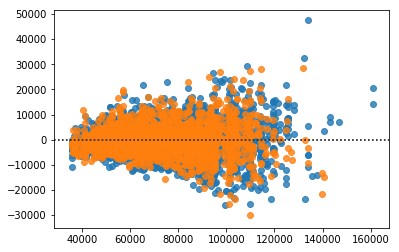

In [25]:
## METRICS
import seaborn as sns
errors_tets = (((y_test - gb_reg_pred_y_test)**2)**0.5)
errors_train = (((y_train - gb_reg_pred_y_train)**2)**0.5)
print("Mean error train:")
print(errors_train.mean())
print(np.median(errors_train))
print("Mean error test:")
print(errors_tets.mean())
print(np.median(errors_tets))

sns.residplot(gb_reg_pred_y_train, y_train, label="train_error");
sns.residplot(gb_reg_pred_y_test, y_test, label="test_error");
plt.show()

In [37]:
param_grid = {
    'model':'RandomForestRegressor',
    'hyper_param':{
        'max_depth': [6,7,8,9,10],
        'n_estimators': [40, 50],#, 60, 70, 80,90, 100]
    }
}

param_grid = {
    'model':'GradientBoostingRegressor',
    'hyper_param':{
        'learning_rate': [0.12,0.1,0.08,0.06],
        'n_estimators': [90, 100,110,120,130]
    }
}

def grid_search(param_grid):
    hyper_param_names = list(param_grid['hyper_param'].keys())
    
    ## define empty 2d array to fill with eval metrics
    model_measures_test =  np.full((len(param_grid['hyper_param'][hyper_param_names[0]]), len(param_grid['hyper_param'][hyper_param_names[1]])), 0)
    model_measures_train =  np.full((len(param_grid['hyper_param'][hyper_param_names[0]]), len(param_grid['hyper_param'][hyper_param_names[1]])), 0)
    
    for i,param_1 in enumerate(param_grid['hyper_param'][hyper_param_names[0]]):
        for j,param_2 in enumerate(param_grid['hyper_param'][hyper_param_names[1]]):
            parameters = {}
            parameters[hyper_param_names[0]] = param_1
            parameters[hyper_param_names[1]] = param_2
            
            model = GradientBoostingRegressor(**parameters)
            model.fit(X_train[train_data_numerics],y_train)
            model_pred_y_test = model.predict(X_test[train_data_numerics])
            model_pred_y_train = model.predict(X_train[train_data_numerics])

            ### save errors to matrix
            model_output_test_res = (((y_test - model_pred_y_test)**2)**0.5).mean()
            model_output_train_res = (((y_train - model_pred_y_train)**2)**0.5).mean()
            model_measures_test[i,j] = model_output_test_res
            model_measures_train[i,j] = model_output_train_res
            
    return model_measures_test

result = grid_search(param_grid)


<IPython.core.display.Javascript object>


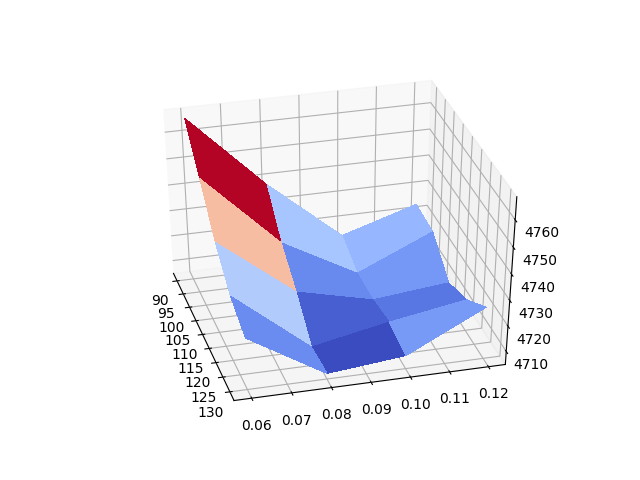

In [45]:

from mpl_toolkits.mplot3d import Axes3D

%matplotlib notebook
fig = plt.figure()
ax = fig.gca(projection='3d')
# Make data.
xx, yy = np.meshgrid(np.asarray(param_grid['hyper_param']["n_estimators"]), np.asarray(param_grid['hyper_param']["learning_rate"]), sparse=True)

# Plot the surface.

surf = ax.plot_surface(xx, yy, result, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)



In [34]:
result

array([[4715, 4721, 4723],
       [4711, 4712, 4710],
       [4716, 4704, 4707]])